### jsmateo 2025, CSCE580 Project B

# Part 1: Models

In [5]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Using hugging face dataset instead of kaggle
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])

In [32]:
print(df.head)

<bound method NDFrame.head of                                                     text  label
0      I rented I AM CURIOUS-YELLOW from my video sto...      0
1      "I Am Curious: Yellow" is a risible and preten...      0
2      If only to avoid making this type of film in t...      0
3      This film was probably inspired by Godard's Ma...      0
4      Oh, brother...after hearing about this ridicul...      0
...                                                  ...    ...
24995  A hit at the time but now better categorised a...      1
24996  I love this movie like no other. Another time ...      1
24997  This film and it's sequel Barry Mckenzie holds...      1
24998  'The Adventures Of Barry McKenzie' started lif...      1
24999  The story centers around Barry McKenzie who mu...      1

[25000 rows x 2 columns]>


### Preprocessing / Cleaning data

In [33]:
# Make all text lowercase
df['text'] = df['text'].str.lower()

In [34]:
# Remove HTML tags
import re
def remove_html_tags(text):
  pattern = re.compile('<.*?>')
  return pattern.sub(r'', text)

In [35]:
df['text'] = df['text'].apply(remove_html_tags)

In [36]:
# Remove special characters and punctuation
def remove_special_characters(text):
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)
  return text

In [37]:
df['text'] = df['text'].apply(remove_special_characters)

In [38]:
# Remove extra spaces
def remove_extra_spaces(text):
  text = re.sub(r'\s+', ' ', text)
  return text.strip()

In [39]:
df['text'] = df['text'].apply(remove_extra_spaces)

In [40]:
# Cleaned review
df['text'][1]

'i am curious yellow is a risible and pretentious steaming pile it doesn t matter what one s political views are because this film can hardly be taken seriously on any level as for the claim that frontal male nudity is an automatic nc that isn t true i ve seen r rated films with male nudity granted they only offer some fleeting views but where are the r rated films with gaping vulvas and flapping labia nowhere because they don t exist the same goes for those crappy cable shows schlongs swinging in the breeze but not a clitoris in sight and those pretentious indie movies like the brown bunny in which we re treated to the site of vincent gallo s throbbing johnson but not a trace of pink visible on chloe sevigny before crying or implying double standard in matters of nudity the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women there are no genitals on display when actresses appears nude and the same cannot be said for a man in fac

#### Q. Discuss any data splitting (e.g., train/test split, stratified sampling).

The train test split will be an 80/20 ratio. Stratified sampling will be used to ensure equal representation of positive and negative reviews across both sets.

### Fine-Tuning DistilBERT with PyTorch

In [6]:
# imports
import torch
import transformers
from transformers import(
    DistilBertModel, DistilBertTokenizerFast,
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score,
    precision_score, recall_score, classification_report)

from datasets import Dataset, DatasetDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df["label"].value_counts()

,count
label,
0,12500
1,12500


In [41]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=0,
    stratify=df["label"]
)
print("Training Set")
print(len(train_texts))
print(sum(train_labels))
print(len(train_labels) - sum(train_labels))
print("Test Set")
print(len(test_texts))
print(sum(test_labels))
print(len(test_labels) - sum(test_labels))

Training Set
20000
10000
10000
Test Set
5000
2500
2500


In [13]:
# Distilbert Model and Tokenization
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2, #pos,neg
    id2label={0: "neg", 1: "pos"},
    label2id={"neg": 0, "pos": 1}
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_text(text):
  return tokenizer(
      text,
      padding=True,
      truncation=True,
      max_length=512
  )

train_tokens = tokenize_text(train_texts)
test_tokens = tokenize_text(test_texts)

# Create dataset objects for Trainer
train_dataset = Dataset.from_dict({
    "input_ids" : train_tokens["input_ids"],
    "attention_mask" : train_tokens["attention_mask"],
    "labels" : train_labels
})

test_dataset = Dataset.from_dict({
    "input_ids" : test_tokens["input_ids"],
    "attention_mask" : test_tokens["attention_mask"],
    "labels" : test_labels
})

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)

In [ ]:
# Compute metrics
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  accuracy = accuracy_score(labels, predictions)
  f1 = f1_score(labels, predictions, average="binary")
  precision = precision_score(labels, predictions, average='binary')
  recall = recall_score(labels, predictions, average='binary')

  return{
      "accuracy": accuracy,
      "f1": f1,
      "precision": precision,
      "recall": recall
  }

In [ ]:
# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

/tmp/ipython-input-585461062.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Begin training
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.250200,0.243171,0.912600,0.913959,0.899961,0.928400
2,0.149300,0.276157,0.913800,0.916424,0.889349,0.945200
3,0.052900,0.383351,0.918600,0.918649,0.918098,0.919200


In [ ]:
results = trainer.evaluate()

In [ ]:
print(results)

{'eval_loss': 0.24317090213298798, 'eval_accuracy': 0.9126, 'eval_f1': 0.91395944083481, 'eval_precision': 0.8999612252811167, 'eval_recall': 0.9284, 'eval_runtime': 35.9009, 'eval_samples_per_second': 139.272, 'eval_steps_per_second': 4.373, 'epoch': 3.0}


In [ ]:
# Save for later
save_path = "/content/imbd_finetuned"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)


('/content/imbd_finetuned/tokenizer_config.json',
 '/content/imbd_finetuned/special_tokens_map.json',
 '/content/imbd_finetuned/vocab.txt',
 '/content/imbd_finetuned/added_tokens.json',
 '/content/imbd_finetuned/tokenizer.json')

In [19]:
# Re-import model for evaluation
model_path = "./imbd_finetuned"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

#### Pre-trained DistilBERT

In [9]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2, #pos,neg
    id2label={0: "neg", 1: "pos"},
    label2id={"neg": 0, "pos": 1}
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
base_args = TrainingArguments(
    output_dir="./base_results",
    per_device_eval_batch_size=32,
    report_to="none"
)

base_trainer = Trainer(
    model=base_model,
    args=base_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1999138208.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  base_trainer = Trainer(


In [ ]:
base_results = base_trainer.evaluate()

In [ ]:
print(base_results)

{'eval_loss': 0.694761335849762, 'eval_model_preparation_time': 0.0015, 'eval_accuracy': 0.467, 'eval_f1': 0.3036320877972302, 'eval_precision': 0.43782969103240393, 'eval_recall': 0.2324, 'eval_runtime': 36.624, 'eval_samples_per_second': 136.522, 'eval_steps_per_second': 4.287}


### Fine-tuned vs. Pre-trained DistilBERT Comparison

In [ ]:
comparison = {
    "Fine-tuned DistilBERT": {"Accuracy": 0.9126, "Precision": 0.8999, "Recall": 0.9284, "F1": 0.9139},
    "Pre-trained DistilBERT": {"Accuracy": 0.467, "Precision": 0.4378, "Recall": 0.2324, "F1": 0.3036},
}
pd.DataFrame(comparison).T

,Accuracy,Precision,Recall,F1
Fine-tuned DistilBERT,0.9126,0.8999,0.9284,0.9139
Pre-trained DistilBERT,0.4670,0.4378,0.2324,0.3036


#### GPT-2

In [25]:
from transformers import GPT2ForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
MODEL_NAME = "openai-community/gpt2"
gpt2_model = GPT2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2, #pos,neg
    id2label={0: "neg", 1: "pos"},
    label2id={"neg": 0, "pos": 1},
    pad_token_id=tokenizer.eos_token_id
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Re-tokenize data for GPT-2
tokenizer.pad_token = tokenizer.eos_token
def tokenize_gpt(text):
  return tokenizer(
      text,
      padding=True,
      truncation=True,
  )

test_tokens = tokenize_gpt(test_texts)

In [ ]:
gpt2_dataset = Dataset.from_dict({
    "input_ids" : test_tokens["input_ids"],
    "attention_mask" : test_tokens["attention_mask"],
    "labels" : test_labels
})

In [ ]:
gpt2_args = TrainingArguments(
    output_dir="./gpt2_results",
    per_device_eval_batch_size=32,
    report_to="none"
)

gpt2_trainer = Trainer(
    model=gpt2_model,
    args=gpt2_args,
    eval_dataset=gpt2_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1196922122.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  gpt2_trainer = Trainer(


In [ ]:
gpt2_results = gpt2_trainer.evaluate()

In [ ]:
print(gpt2_results)

{'eval_loss': 0.7437634468078613, 'eval_model_preparation_time': 0.0021, 'eval_accuracy': 0.501, 'eval_f1': 0.1254819488257974, 'eval_precision': 0.5070821529745042, 'eval_recall': 0.0716, 'eval_runtime': 180.1653, 'eval_samples_per_second': 27.752, 'eval_steps_per_second': 0.871}


### Fine-tuned DistilBERT vs. GPT2 Comparison

In [ ]:
comparison = {
    "Fine-tuned DistilBERT": {"Accuracy": 0.9126, "Precision": 0.8999, "Recall": 0.9284, "F1": 0.9139},
    "GPT-2": {"Accuracy": 0.501, "Precision": 0.5070, "Recall": 0.0716, "F1": 0.1254}
}
pd.DataFrame(comparison).T

,Accuracy,Precision,Recall,F1
Fine-tuned DistilBERT,0.9126,0.8999,0.9284,0.9139
GPT-2,0.5010,0.5070,0.0716,0.1254


### Classical Machine Learning Model: Logistic Regression

In [11]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print(X_train_tfidf.shape)

(20000, 67597)


In [43]:
# Logistic Regression
logreg = LogisticRegression(C=1e5)
model = logreg.fit(X_train_tfidf, train_labels)

In [ ]:
print (' Model details:')
print (' -  intercept : ', model.intercept_)
print (' -  coeff : ', model.coef_)

 Model details:
 -  intercept :  [-3.08259916]
 -  coeff :  [[-8.06787231 -5.53216201 -0.24345124 ... -0.79141839 -0.3020565
  -0.3020565 ]]


In [ ]:
# Predicted values
y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

In [ ]:
# Evaluate
logreg_accuracy = accuracy_score(test_labels, y_pred_test)
logreg_f1 = f1_score(test_labels, y_pred_test, average="binary")
logreg_precision = precision_score(test_labels, y_pred_test, average="binary")
logreg_recall = recall_score(test_labels, y_pred_test, average="binary")

print(f"Logistic Regression Evaluation- eval_acc: {logreg_accuracy}, eval_f1: {logreg_f1}, eval_precision: {logreg_precision}, eval_recall: {logreg_recall}")

Logistic Regression Evaluation- eval_acc: 0.884, eval_f1: 0.8847834723877632, eval_precision: 0.8788476716653513, eval_recall: 0.8908


### Fine-tuned DistilBERT vs. Pre-Trained DistilBERT vs. Logistic Regression

In [ ]:
comparison = {
    "Fine-tuned DistilBERT": {"Accuracy": 0.9126, "Precision": 0.8999, "Recall": 0.9284, "F1": 0.9139},
    "Pre-trained DistilBERT": {"Accuracy": 0.467, "Precision": 0.4378, "Recall": 0.2324, "F1": 0.3036},
    "Logistic Regression": {"Accuracy": 0.884, "Precision": 0.8788, "Recall": 0.8908, "F1": 0.8847}
}
pd.DataFrame(comparison).T

,Accuracy,Precision,Recall,F1
Fine-tuned DistilBERT,0.9126,0.8999,0.9284,0.9139
Pre-trained DistilBERT,0.4670,0.4378,0.2324,0.3036
Logistic Regression,0.8840,0.8788,0.8908,0.8847


# Part 2: Analysis and Graphs
The results and my comments/discussions for this section will be included in the required PDF. This section is basically used to create all relevant graphs.

## AI Testcases

In [ ]:
!pip install gaico

In [3]:
# Imports
from gaico import Experiment

In [23]:
# Fine-tuned DistilBERT and Pretrained/Base DistilBERT
reviews = [
# TC-1
"This movie was great!",
# TC-2
"""The movie was not great. It had its ups and downs throughout but overall it failed to really hook me with the story. The soundtrack and visuals were nice but the acting
left a lot to be desired. The story itself was bland and did not help with everything else considered. Overall would not recommend.""",
# TC-3
"""This movie is the pinnacle of everything no one wants to see in a horror movie. Truly a masterpiece I'd say, if I was wearing a blindfold with headphones on.
I loved how instead of building suspense, the director decided to desensitize the entire audience to anything remotely spooky with cheap jumpscares every 30 seconds.
The emotion shown by the actors really drew me in, towards the exit of the cinema. Would highly recommend to those who love cheap jumpscares, and emotionless acting."""
]
# Tokenize
inputs = tokenizer(reviews, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Get prediction
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

base_model.eval()
with torch.no_grad():
  base_outputs = base_model(**inputs)


# Get the predicted label
predictions = torch.argmax(outputs.logits, dim=1)
base_predictions = torch.argmax(base_outputs.logits, dim=1)


print("Fine-Tuned DistilBERT")
for i, pred in enumerate(predictions):
  sentiment = model.config.id2label[pred.item()]
  print(f"TC-{i+1} Prediction: {sentiment}")

print("Base DistilBERT")
for i, pred in enumerate(base_predictions):
  sentiment = base_model.config.id2label[pred.item()]
  print(f"TC-{i+1} Prediction: {sentiment}")

Fine-Tuned DistilBERT
TC-1 Prediction: pos
TC-2 Prediction: neg
TC-3 Prediction: pos
Base DistilBERT
TC-1 Prediction: neg
TC-2 Prediction: neg
TC-3 Prediction: neg


In [28]:
# GPT-2
reviews = [
# TC-1
"This movie was great!",
# TC-2
"""The movie was not great. It had its ups and downs throughout but overall it failed to really hook me with the story. The soundtrack and visuals were nice but the acting
left a lot to be desired. The story itself was bland and did not help with everything else considered. Overall would not recommend.""",
# TC-3
"""This movie is the pinnacle of everything no one wants to see in a horror movie. Truly a masterpiece I'd say, if I was wearing a blindfold with headphones on.
I loved how instead of building suspense, the director decided to desensitize the entire audience to anything remotely spooky with cheap jumpscares every 30 seconds.
The emotion shown by the actors really drew me in, towards the exit of the cinema. Would highly recommend to those who love cheap jumpscares, and emotionless acting."""
]
# Tokenize
tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer(reviews, padding=True, truncation=True, max_length=512, return_tensors="pt")

gpt2_model.eval()
with torch.no_grad():
    gpt2_outputs = gpt2_model(**inputs)
    gpt2_predictions = torch.argmax(gpt2_outputs.logits, dim=1)

id2label = gpt2_model.config.id2label

print("GPT-2")
for i, pred in enumerate(gpt2_predictions):
    print(f"TC-{i+1}: {id2label[pred.item()]}")

GPT-2
TC-1: pos
TC-2: pos
TC-3: pos


In [44]:
# Logistic Regression
X_test_cases = tfidf_vectorizer.transform(reviews)
predictions = model.predict(X_test_cases)
label_map = {0: "neg", 1:"pos"}
for i, review in enumerate(reviews):
    print(f"TC-{i+1}: {label_map[predictions[i]]}")

TC-1: pos
TC-2: pos
TC-3: neg


In [57]:
# Comparison using GAICo

llm_responses = {
    "Fine-tuned DistilBERT": ["pos","neg","pos"],
    "Base DistilBERT": ["neg","neg","neg"],
    "GPT-2": ["pos","pos","pos"],
    "Logistic Regression": ["pos","pos","neg"]
}

reference_answers = ["pos","neg","neg"]

In [58]:
exp = Experiment(llm_responses=llm_responses, reference_answer=reference_answers)

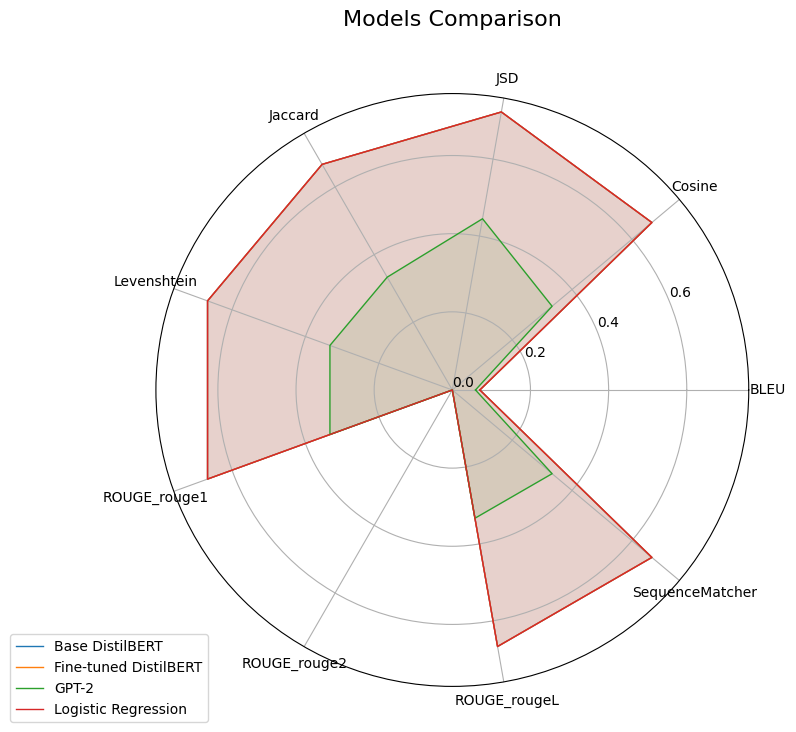

CSV report generated at: model_report.csv


In [63]:
results_df = exp.compare(
    metrics = None,
    plot = True,
    output_csv_path="model_report.csv"
)


## Accuracy and Loss Curves

In [ ]:
log_history = trainer.state.log_history
logs_df = pd.DataFrame(log_history)

In [ ]:
print(logs_df.head())

     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.4872   4.751069       0.000049   0.08   100        NaN            NaN   
1  0.3173   1.199574       0.000047   0.16   200        NaN            NaN   
2  0.3184   3.087356       0.000046   0.24   300        NaN            NaN   
3  0.3290   6.770905       0.000045   0.32   400        NaN            NaN   
4  0.2997  10.270666       0.000043   0.40   500        NaN            NaN   

   eval_f1  eval_precision  eval_recall  eval_runtime  \
0      NaN             NaN          NaN           NaN   
1      NaN             NaN          NaN           NaN   
2      NaN             NaN          NaN           NaN   
3      NaN             NaN          NaN           NaN   
4      NaN             NaN          NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                      NaN                    NaN   

In [ ]:
# Separate training and eval logs
train_logs = logs_df[logs_df["loss"].notna()]
eval_logs = logs_df[logs_df["eval_loss"].notna()]

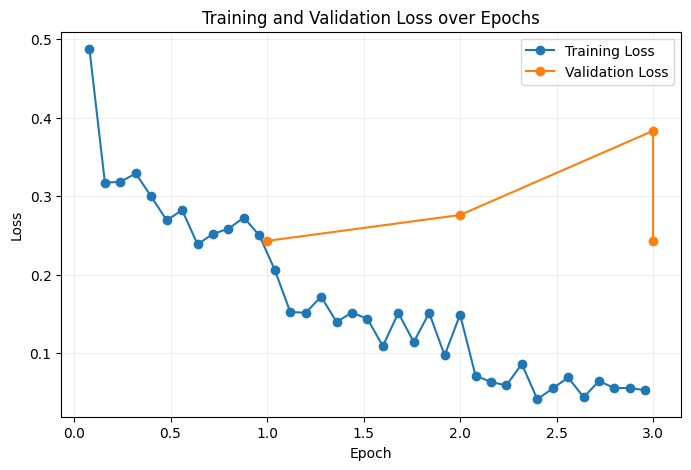

In [ ]:
# Training vs Loss
plt.figure(figsize=(8,5))
plt.plot(train_logs["epoch"], train_logs["loss"], label="Training Loss", marker='o')
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

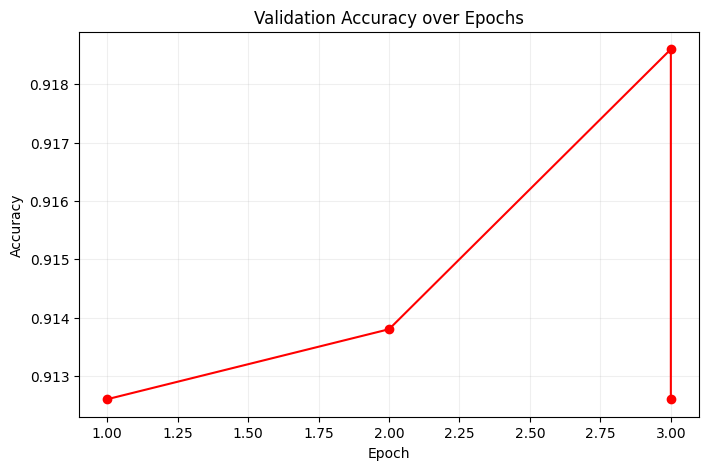

In [ ]:
# Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_accuracy"], color="red", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid(alpha=0.2)
plt.show()

## Confusion Matrices

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Fine tuned distilBERT
pred_output = trainer.predict(test_dataset)

In [ ]:
logits=pred_output.predictions
labels=pred_output.label_ids

In [ ]:
y_pred = np.argmax(logits, axis=1)
y_true = labels

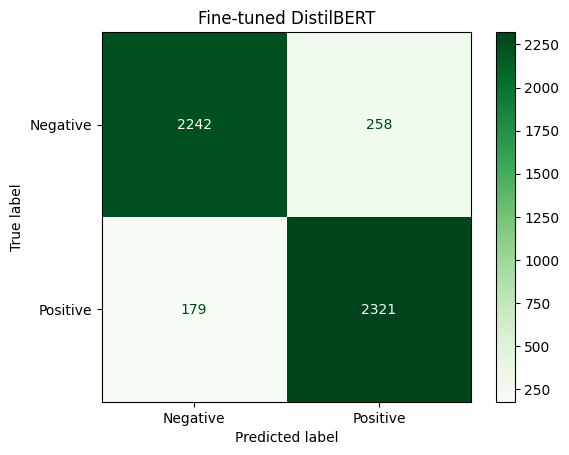

In [ ]:
CM = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(CM, display_labels=["Negative", "Positive"]).plot(cmap="Greens")
plt.title("Fine-tuned DistilBERT")
plt.show()

In [ ]:
# Pre-trained/Base Distilbert
pred_output = base_trainer.predict(test_dataset)

In [ ]:
y_pred_base = np.argmax(pred_output.predictions, axis=1)
y_true = pred_output.label_ids

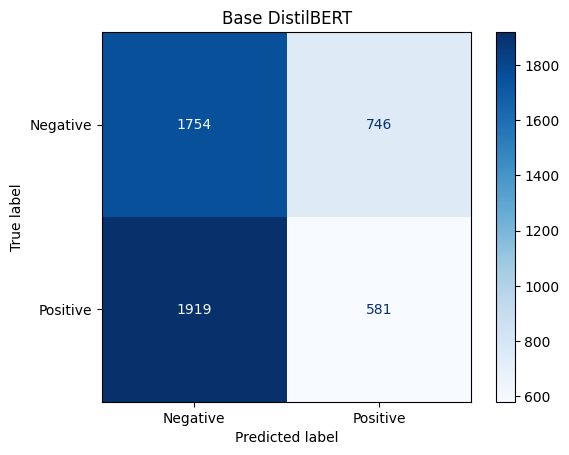

In [ ]:
CM_base = confusion_matrix(y_true, y_pred_base)
ConfusionMatrixDisplay(CM_base, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
plt.title("Base DistilBERT")
plt.show()

In [ ]:
# Logistic Regression (Classical Model)


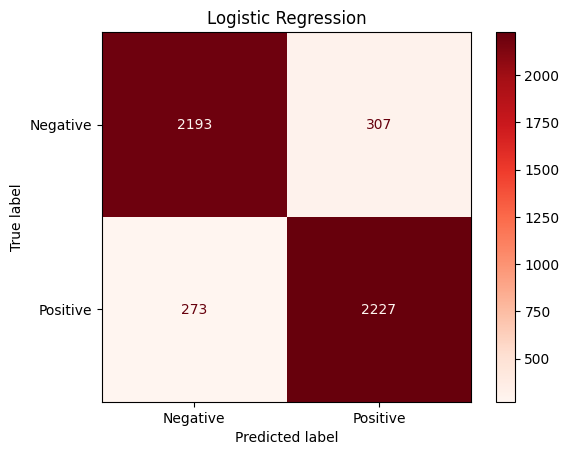

In [ ]:
CM_logreg = confusion_matrix(test_labels, y_pred_test)
ConfusionMatrixDisplay(CM_logreg, display_labels=["Negative", "Positive"]).plot(cmap="Reds")
plt.title("Logistic Regression")
plt.show()

## Performance Comparison

In [ ]:
comparison = {
    "Fine-tuned DistilBERT": {"Accuracy": 0.9126, "Precision": 0.8999, "Recall": 0.9284, "F1": 0.9139},
    "Pre-trained DistilBERT": {"Accuracy": 0.467, "Precision": 0.4378, "Recall": 0.2324, "F1": 0.3036},
    "GPT-2": {"Accuracy": 0.501, "Precision": 0.5070, "Recall": 0.0716, "F1": 0.1254},
    "Logistic Regression": {"Accuracy": 0.884, "Precision": 0.8788, "Recall": 0.8908, "F1": 0.8847}
}
pd.DataFrame(comparison).T

,Accuracy,Precision,Recall,F1
Fine-tuned DistilBERT,0.9126,0.8999,0.9284,0.9139
Pre-trained DistilBERT,0.4670,0.4378,0.2324,0.3036
GPT-2,0.5010,0.5070,0.0716,0.1254
Logistic Regression,0.8840,0.8788,0.8908,0.8847
